# Data analysis for mamography image

### Imports

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger

import tensorflow as tf

import pickle

from sklearn.metrics import classification_report,confusion_matrix

##### Import data
Image data are splited and save seperatly as folders for  ,train , validation and test

In [131]:
# Paths
train_dir = "C:/Users/Sreerag/Documents/ML_chellange/Brest-Cancer-classifier/data/raw/model_2/train"
val_dir   = "C:/Users/Sreerag/Documents/ML_chellange/Brest-Cancer-classifier/data/raw/model_2/val"
test_dir  = "C:/Users/Sreerag/Documents/ML_chellange/Brest-Cancer-classifier/data/raw/model_2/test"

#### Split data

In [132]:
# Load training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # resize images
    batch_size=64,
    label_mode="int",  color_mode="rgb"       # returns 0 (benign), 1 (malignant)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode="int"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode="int"
)

Found 3816 files belonging to 2 classes.
Found 1908 files belonging to 2 classes.
Found 1908 files belonging to 2 classes.


#### Initial Analysis

In [133]:
# Check class names (labels)
print(train_ds.class_names)  # ['benign', 'malignant']

['Benign', 'Malignant']


In [134]:
imgs, labels = next(iter(train_ds))

In [135]:
# Check the shape of images and labels
imgs.shape, labels.shape

(TensorShape([64, 224, 224, 3]), TensorShape([64]))

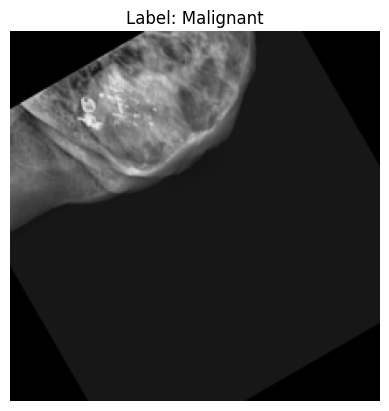

In [158]:
# Convert to numpy for visualization
first_img = imgs[1].numpy()
first_label = labels[1].numpy()

# Map class indices to names
class_names = ['Benign', 'Malignant']

# Plot the first image
plt.imshow(first_img.astype("uint8"))
plt.axis("off")
plt.title(f"Label: {class_names[int(first_label)]}")
plt.show()

### Model selection
As a starting point, a simple convolutional neural network (CNN) was implemented to establish a baseline for the classification task. The model uses multiple convolution and pooling layers for feature extraction, followed by fully connected layers with dropout to reduce overfitting, and a sigmoid activation in the output layer for binary prediction. This serves as an initial benchmark before exploring more complex models and transfer learning techniques.

In [137]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [138]:

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,797,665 (10.67 MB)

 Trainable params: 2,797,665 (10.67 MB)

 Non-trainable params: 0 (0.00 B)

### Train of Model

In [139]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [140]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,           # change epochs later
    batch_size=32        # batch size is already set in dataset
)


Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 510ms/step - accuracy: 0.6439 - loss: 2.8876 - val_accuracy: 0.6709 - val_loss: 0.6447
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 549ms/step - accuracy: 0.6677 - loss: 0.6608 - val_accuracy: 0.6719 - val_loss: 0.6319
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 806ms/step - accuracy: 0.6751 - loss: 0.6537 - val_accuracy: 0.6672 - val_loss: 0.6395
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 864ms/step - accuracy: 0.6711 - loss: 0.6288 - val_accuracy: 0.6866 - val_loss: 0.6109
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 861ms/step - accuracy: 0.7049 - loss: 0.5438 - val_accuracy: 0.7107 - val_loss: 0.5965
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 870ms/step - accuracy: 0.7568 - loss: 0.4870 - val_accuracy: 0.7206 - val_loss: 0.5662
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 2637s 45s/step - accuracy: 0.8077 - loss: 0.4032 - val_accuracy: 0.7699 - val_loss: 0.5255
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 872ms/step - accuracy: 0.8506 - loss: 0.3373 - val_accu

### Evaluation

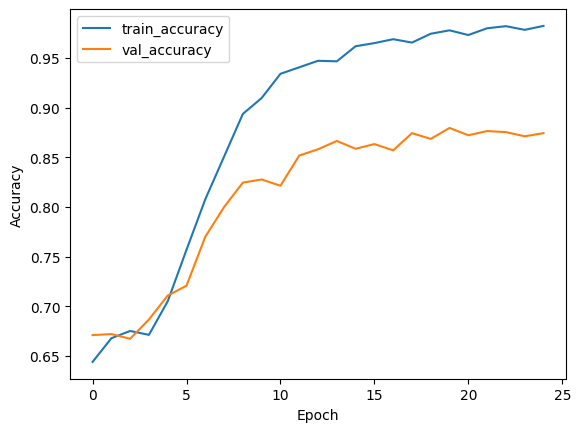

In [141]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The baseline CNN achieved a training accuracy of 97.5% and a loss of 0.068, with a validation accuracy of 86.3% and a loss of 0.522. The results show the model learns the training data well, though there is some overfitting, suggesting potential improvements with data augmentation or more advanced architectures.

### Test of model

In [142]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.8726 - loss: 0.7052
Test Loss: 0.7052
Test Accuracy: 0.8726


##### prediction 

In [143]:
# Get model predictions
y_pred_prob = model.predict(test_ds)
y_pred_classes = np.where(y_pred_prob > 0.5, 1, 0)

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step


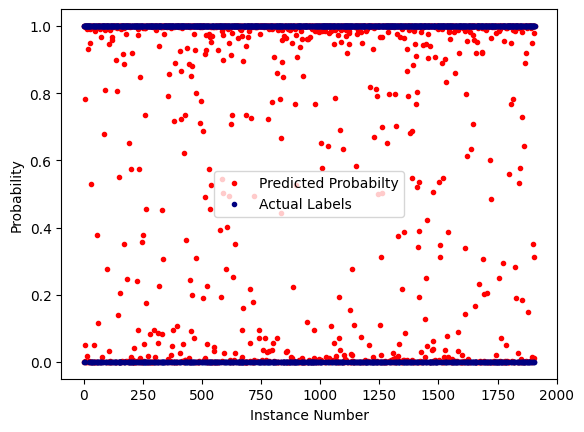

In [144]:
plt.plot(y_pred_prob,'.',color='red',label='Predicted Probabilty')
plt.plot(y_true,'.',color='navy',label='Actual Labels')
plt.xlabel('Instance Number')
plt.ylabel('Probability')
plt.legend()

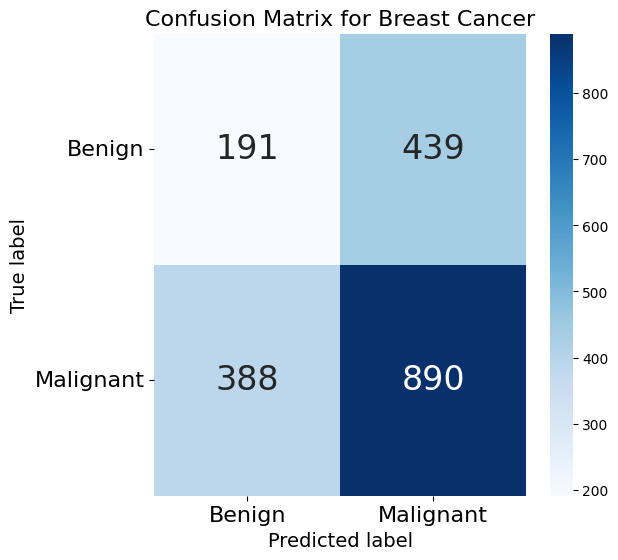

In [145]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 24}, fmt='g')

# Correct tick positions and labels
plt.xticks([0.5, 1.5], ['Benign','Malignant'], fontsize=16)
plt.yticks([0.5, 1.5], ['Benign','Malignant'], fontsize=16, rotation=0)

plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title('Confusion Matrix for Breast Cancer', fontsize=16)
plt.show()


In [146]:
# Print detailed classification report
print(classification_report(y_true, y_pred_classes, target_names=['benign','malignant']))

              precision    recall  f1-score   support

      benign       0.33      0.30      0.32       630
   malignant       0.67      0.70      0.68      1278

    accuracy                           0.57      1908
   macro avg       0.50      0.50      0.50      1908
weighted avg       0.56      0.57      0.56      1908



The higher recall and precision for the malignant class compared to benign indicate that the model is biased towards predicting malignant cases. While it captures malignant cases reasonably well, it struggles with benign classification. This suggests the need for improvements such as data balancing, augmentation, or more advanced architectures to achieve better generalization.

#### Compurt ROC curve and AUC

In [147]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc_score = roc_auc_score(y_true, y_pred_prob)

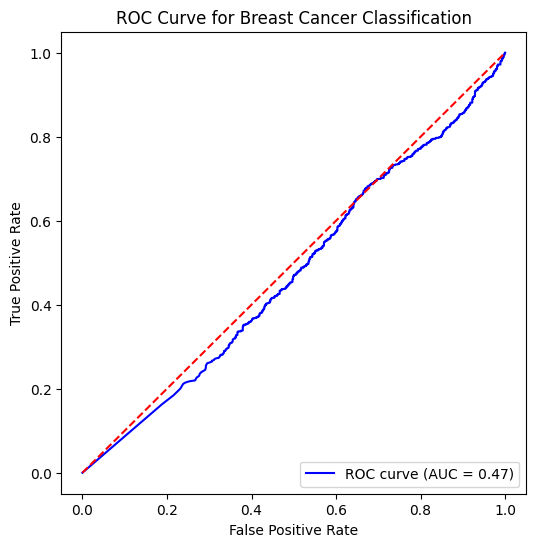

In [148]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend(loc='lower right')
plt.show()

The ROC curve for the model lies below the diagonal line, indicating that the model is performing worse than random guessing in distinguishing between benign and malignant cases. The low AUC reflects poor discriminative ability, suggesting that the current model is not suitable for reliable classification. Significant improvements are needed

### prediction on test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


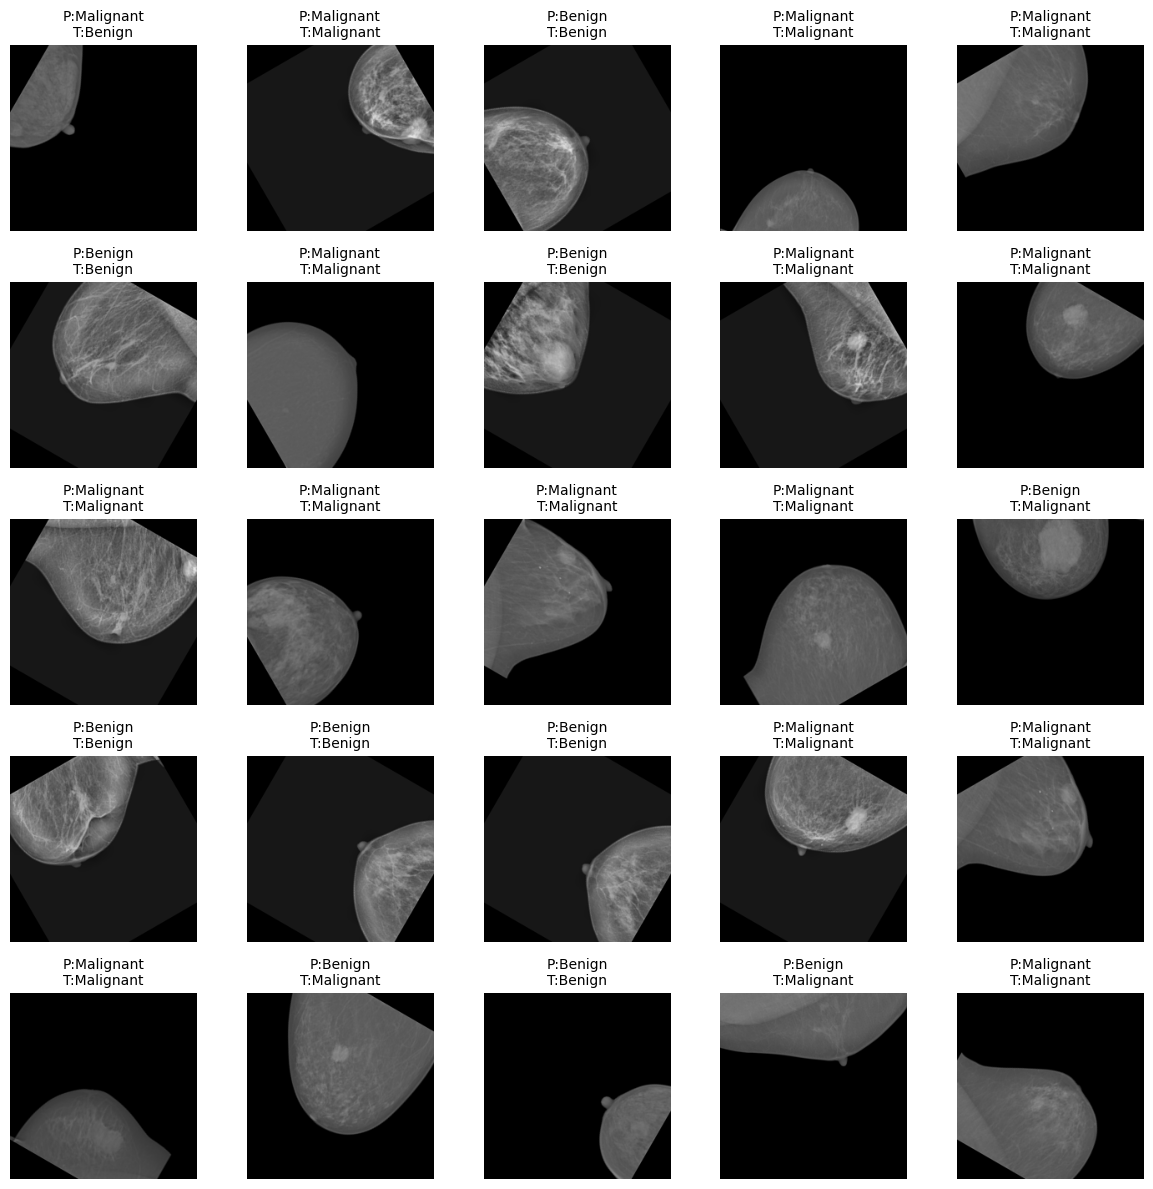

In [150]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to show
num_images = 25  # 5x5 grid

# Get a batch of images and labels from test dataset
images, labels = next(iter(test_ds))  # TensorFlow tensors
images = images[:num_images]
labels = labels[:num_images]

# Convert tensors to numpy for plotting
images_np = images.numpy()
labels_np = labels.numpy()

# Get predictions
pred_probs = model.predict(images_np)
pred_classes = np.where(pred_probs > 0.5, 1, 0)

# Map class numbers to names
class_names = ['Benign', 'Malignant']

# Plot 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.flatten()

for img, true_label, pred_label, ax in zip(images_np, labels_np, pred_classes, axes):
    ax.imshow(img.astype("uint8"))
    ax.axis('off')
    ax.set_title(f"P:{class_names[pred_label[0]]}\nT:{class_names[int(true_label)]}", fontsize=10)

plt.tight_layout()
plt.show()
